Ici, nous récupérons les fichiers du code originel:

In [1]:
!git clone https://github.com/FlyingGiraffe/vnn.git
%cd vnn


Cloning into 'vnn'...
remote: Enumerating objects: 92, done.
remote: Counting objects: 100% (44/44), done.
remote: Compressing objects: 100% (24/24), done.
remote: Total 92 (delta 30), reused 20 (delta 20), pack-reused 48 (from 1)
Receiving objects: 100% (92/92), 1.02 MiB | 4.06 MiB/s, done.
Resolving deltas: 100% (35/35), done.
/content/vnn


Ce code crée un dossier data dans /content/vnn et se place dedans pour y stocker ou manipuler des fichiers.

In [2]:
%cd /content/vnn
!mkdir -p data
%cd data


/content/vnn
/content/vnn/data


Cette commande télécharge le jeu de données d'entraînement `modelnet40_normal_resampled.zip` depuis Internet (via l’URL donnée) dans le dossier courant, en ignorant les problèmes de certificat SSL. Puis dezip l'archive (cela prendra 1 à2min en fonction de la connexion internet).


In [3]:
!wget --no-check-certificate https://web.archive.org/web/20211112014708/https://shapenet.cs.stanford.edu/media/modelnet40_normal_resampled.zip
!unzip modelnet40_normal_resampled.zip



Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
  inflating: modelnet40_normal_resampled/sofa/sofa_0412.txt  
  inflating: modelnet40_normal_resampled/sofa/sofa_0473.txt  
  inflating: modelnet40_normal_resampled/sofa/sofa_0258.txt  
  inflating: modelnet40_normal_resampled/sofa/sofa_0663.txt  
  inflating: modelnet40_normal_resampled/sofa/sofa_0384.txt  
  inflating: modelnet40_normal_resampled/sofa/sofa_0362.txt  
  inflating: modelnet40_normal_resampled/sofa/sofa_0048.txt  
  inflating: modelnet40_normal_resampled/sofa/sofa_0344.txt  
  inflating: modelnet40_normal_resampled/sofa/sofa_0027.txt  
  inflating: modelnet40_normal_resampled/sofa/sofa_0288.txt  
  inflating: modelnet40_normal_resampled/sofa/sofa_0682.txt  
  inflating: modelnet40_normal_resampled/sofa/sofa_0432.txt  
  inflating: modelnet40_normal_resampled/sofa/sofa_0702.txt  
  inflating: modelnet40_normal_resampled/sofa/sofa_0083.txt  
  inflating: modelnet40_normal_resampled/sofa/sofa_024

Ces commandes affichent le contenu du dossier courant (`!ls`) puis celui du sous-dossier `modelnet40_normal_resampled` et change le répertoire courant du notebook pour /content/vnn.


In [4]:
!ls
!ls modelnet40_normal_resampled
%cd /content/vnn



modelnet40_normal_resampled  modelnet40_normal_resampled.zip
airplane   cup		 lamp			     night_stand  table
bathtub    curtain	 laptop			     person	  tent
bed	   desk		 mantel			     piano	  toilet
bench	   door		 modelnet10_shape_names.txt  plant	  tv_stand
bookshelf  dresser	 modelnet10_test.txt	     radio	  vase
bottle	   filelist.txt  modelnet10_train.txt	     range_hood   wardrobe
bowl	   flower_pot	 modelnet40_shape_names.txt  sink	  xbox
car	   glass_box	 modelnet40_test.txt	     sofa
chair	   guitar	 modelnet40_train.txt	     stairs
cone	   keyboard	 monitor		     stool
/content/vnn


ici, on importe PyTorch et on vérifie si un GPU compatible CUDA est disponible pour l’accélération, en affichant True si oui et False sinon.

In [5]:
import torch
print(torch.cuda.is_available())


True


Ce code ci-dessous permet de monter Google Drive dans le notebook pour accéder à vos fichiers directement depuis Colab.

⚠️ Lors de l’exécution, vous devrez accepter les différentes demandes d’autorisation Google et copier-coller le code de validation fourni.

In [6]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


Ensuite, on importe torch

In [ ]:
import torch
print(torch.__version__)
print(torch.version.cuda)


2.9.0+cu126
12.6


Cette commande installe PyTorch3D directement depuis le dépôt GitHub de Facebook Research, avec le niveau de détail maximal (-vvv) pour afficher toutes les étapes de l’installation. ⚠️ Cette installation prend en moyenne 30 à 35 minutes.

Cette installation prend du temps car PyTorch3D est installé depuis le code source et non via un package précompilé.
Pendant l’installation, ses extensions C++ et CUDA sont compilées pour correspondre à votre GPU.
C’est cette compilation qui fait que l’opération peut durer 30 minutes ou plus.

In [7]:
!pip install 'git+https://github.com/facebookresearch/pytorch3d.git'


Using pip 24.1.2 from /usr/local/lib/python3.12/dist-packages/pip (python 3.12)
Non-user install because site-packages writeable
Created temporary directory: /tmp/pip-build-tracker-m5f5d68i
Initialized build tracking at /tmp/pip-build-tracker-m5f5d68i
Created build tracker: /tmp/pip-build-tracker-m5f5d68i
Entered build tracker: /tmp/pip-build-tracker-m5f5d68i
Created temporary directory: /tmp/pip-install-h0dnha59
Created temporary directory: /tmp/pip-ephem-wheel-cache-omkvfa9r
  Created temporary directory: /tmp/pip-req-build-mmnfbq7w
  Cloning https://github.com/facebookresearch/pytorch3d.git to /tmp/pip-req-build-mmnfbq7w
  Running command git version
  git version 2.34.1
  Running command git clone --filter=blob:none --verbose --progress https://github.com/facebookresearch/pytorch3d.git /tmp/pip-req-build-mmnfbq7w
  Cloning into '/tmp/pip-req-build-mmnfbq7w'...
  POST git-upload-pack (175 bytes)
  POST git-upload-pack (gzip 1622 to 824 bytes)
  remote: Enumerating objects: 7987, don

Suite à l'installation de PyTorch3D, on vérifie qu'il est correctement installé :

In [8]:
from pytorch3d.transforms import RotateAxisAngle
print("PyTorch3D installé correctement")


PyTorch3D installé correctement


La commande ci-dessous entraîne un modèle VN-PointNet pour la classification de nuages de points sur ModelNet40.

L’argument --rot définit le type de rotation appliquée aux données d’entrée et peut prendre trois valeurs :

aligned : formes sans rotation (alignées).

z : rotation aléatoire autour de l’axe vertical (Z).

so3 : rotation aléatoire complète dans l’espace 3D.

--log_dir indique le dossier où seront enregistrés les logs et modèles entraînés sur Google Drive.

L'entraînement est assez long, la durée est d'environ 40min pour 10 epochs. Au bout de 10 epochs, nous obtenons seulement 20% d'accuracy. Ce qui est insuffisant mais attendu. En effet, pour obtenir le niveau de précision de l'article, cad environ 80% d'accuracy, il aurait approximativement entrainé le modèle sur 250 epochs soit environ 17h. En pratique, entraîner 25 heures sur GPU dans Google Colab est compliqué car les sessions sont limitées dans le temps, les ressources GPU peuvent être interrompues, et même avec des checkpoints pour reprendre l’entraînement après coup, les petites interruptions et reprises successives auraient encore allongé la durée totale.

In [ ]:
!python train_cls.py --model vn_pointnet_cls --rot aligned --log_dir /content/drive/MyDrive/vnn_logs/dgcnn_aligned


PARAMETER ...
Namespace(model='vn_pointnet_cls', batch_size=32, epoch=250, learning_rate=0.001, decay_rate=0.0001, optimizer='SGD', gpu='0', num_point=1024, log_dir='/content/drive/MyDrive/vnn_logs/dgcnn_aligned', normal=False, num_votes=3, rot='aligned', pooling='mean', n_knn=20)
Load dataset ...
The size of train data is 9843
The size of test data is 2468
No existing model, starting training from scratch...
Epoch 1 (1/250):
100% 308/308 [03:49<00:00,  1.34it/s]
Train Instance Accuracy: 0.124941
100% 78/78 [00:26<00:00,  2.93it/s]
Test Instance Accuracy: 0.118990, Class Accuracy: 0.075207
Best Instance Accuracy: 0.118990, Class Accuracy: 0.075207
Saving at /content/drive/MyDrive/vnn_logs/dgcnn_aligned/checkpoints/best_model.pth
Epoch 2 (2/250):
100% 308/308 [03:51<00:00,  1.33it/s]
Train Instance Accuracy: 0.137976
100% 78/78 [00:27<00:00,  2.83it/s]
Test Instance Accuracy: 0.143429, Class Accuracy: 0.089972
Best Instance Accuracy: 0.143429, Class Accuracy: 0.089972
Saving at /content

`!python test_cls.py --model vn_pointnet_cls --log_dir /content/drive/MyDrive/vnn_logs/dgcnn_aligned`
  teste un modèle VN-PointNet pour la classification de nuages de points sur ModelNet40.

--model choisit le modèle (vn_pointnet_cls ou vn_dgcnn_cls).

--log_dir indique où charger le modèle entraîné.

--rot (optionnel) peut être aligned, z ou so3 pour définir la rotation des données de test.

In [ ]:
!python test_cls.py --model vn_pointnet_cls --log_dir /content/drive/MyDrive/vnn_logs/dgcnn_aligned


Ce code permet de charger le modèle VN-PointNet que nous avons entraîné et de visualiser quelques exemples du dataset de test ModelNet40.

Il importe les bibliothèques nécessaires pour PyTorch, la manipulation de données et la visualisation 3D.

Il charge le dataset de test via ModelNetDataLoader et crée un DataLoader pour itérer sur les nuages de points.

Il initialise le modèle VN-PointNet, charge les poids du meilleur modèle enregistré (best_model.pth) et le met en mode évaluation.

Pour quelques exemples du test set, il prédit la classe avec le modèle et affiche les nuages de points en 3D avec les labels vrais et prédits.

En résumé : ce code sert à tester visuellement et qualitativement le modèle entraîné, en comparant les prédictions aux vraies classes pour un petit nombre de nuages de points.

Comme attendu, il ne reconnait peu voire aucun objet du fait de son court entraînement qui l'amène a une accuracy de seulement 20%.

In [ ]:
import matplotlib.pyplot as plt
import torch
import torch.utils.data as data
import numpy as np
import os
import sys
from mpl_toolkits.mplot3d import Axes3D # Explicitly import for 3D projection

# Add current directory to path to find data_utils and models
sys.path.append(os.getcwd())

# Import data_utils and model
from data_utils.ModelNetDataLoader import ModelNetDataLoader
from models.vn_pointnet_cls import get_model as get_vn_pointnet_model

# Define parameters based on previous training/testing configuration
batch_size = 16 # From test_cls.py output
num_point = 1024 # From train_cls.py/test_cls.py output
log_dir = '/content/drive/MyDrive/vnn_logs/dgcnn_aligned'

# Load dataset
print("Load dataset ...")
# Fix: Update the root path to point to the correct subdirectory where the data resides
TEST_DATASET = ModelNetDataLoader(root='./data/modelnet40_normal_resampled', npoint=num_point, split='test', normal_channel=False)
testDataLoader = torch.utils.data.DataLoader(TEST_DATASET, batch_size=batch_size, shuffle=False, num_workers=4)
print(f"The size of test data is {len(TEST_DATASET)}")

# Initialize and load the classifier
num_class = 40 # ModelNet40 has 40 classes

# Create a dummy args object as required by get_model
class Args:
    def __init__(self):
        self.gpu = '0'
        self.normal = False
        self.n_knn = 20 # Add the missing n_knn attribute
        self.pooling = 'mean' # Add the missing pooling attribute
args = Args()

classifier = get_vn_pointnet_model(args, num_class=num_class, normal_channel=False).cuda()

checkpoint_path = os.path.join(log_dir, 'checkpoints', 'best_model.pth')
print(f"Loading checkpoint from: {checkpoint_path}")
checkpoint = torch.load(checkpoint_path, weights_only=False)
classifier.load_state_dict(checkpoint['model_state_dict'])
classifier.eval() # Set to evaluation mode
print("Classifier and testDataLoader are now defined and ready.")

# Sélection de quelques exemples du test set
examples_to_show = 5  # nombre d'exemples à visualiser
test_iter = iter(testDataLoader)

for i in range(examples_to_show):
    points, target = next(test_iter)  # batch
    points = points.transpose(2, 1).cuda()  # (B, 3, N)
    target = target[:, 0].cuda()

    # Classifier is already in eval mode and on GPU, no need to re-set in loop
    with torch.no_grad():
        pred, _ = classifier(points)
        pred_choice = pred.data.max(1)[1]

    points_np = points[0].cpu().numpy().T  # (N, 3)
    true_label = target[0].item()
    pred_label = pred_choice[0].item()

    # Affichage
    fig = plt.figure(figsize=(5,5))
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(points_np[:,0], points_np[:,1], points_np[:,2], c='b', s=5)
    ax.set_title(f"Vrai: {true_label}, Prédit: {pred_label}")
    ax.view_init(elev=30, azim=45)
    plt.show()


Ici, on refait la même chose, mais sur plus d'exemples. Normalement, il y a au moins une bonne réponse du réseau de neurones mise en vert. Les nuages de points bleu représente un exemple sous plusieurs angles (ici 6).

Loaded label names from /content/vnn/data/modelnet40_normal_resampled/modelnet40_shape_names.txt
Classifier trouvé en mémoire.
Figure saved to: /content/drive/MyDrive/vnn_visualizations/predictions_grid.png


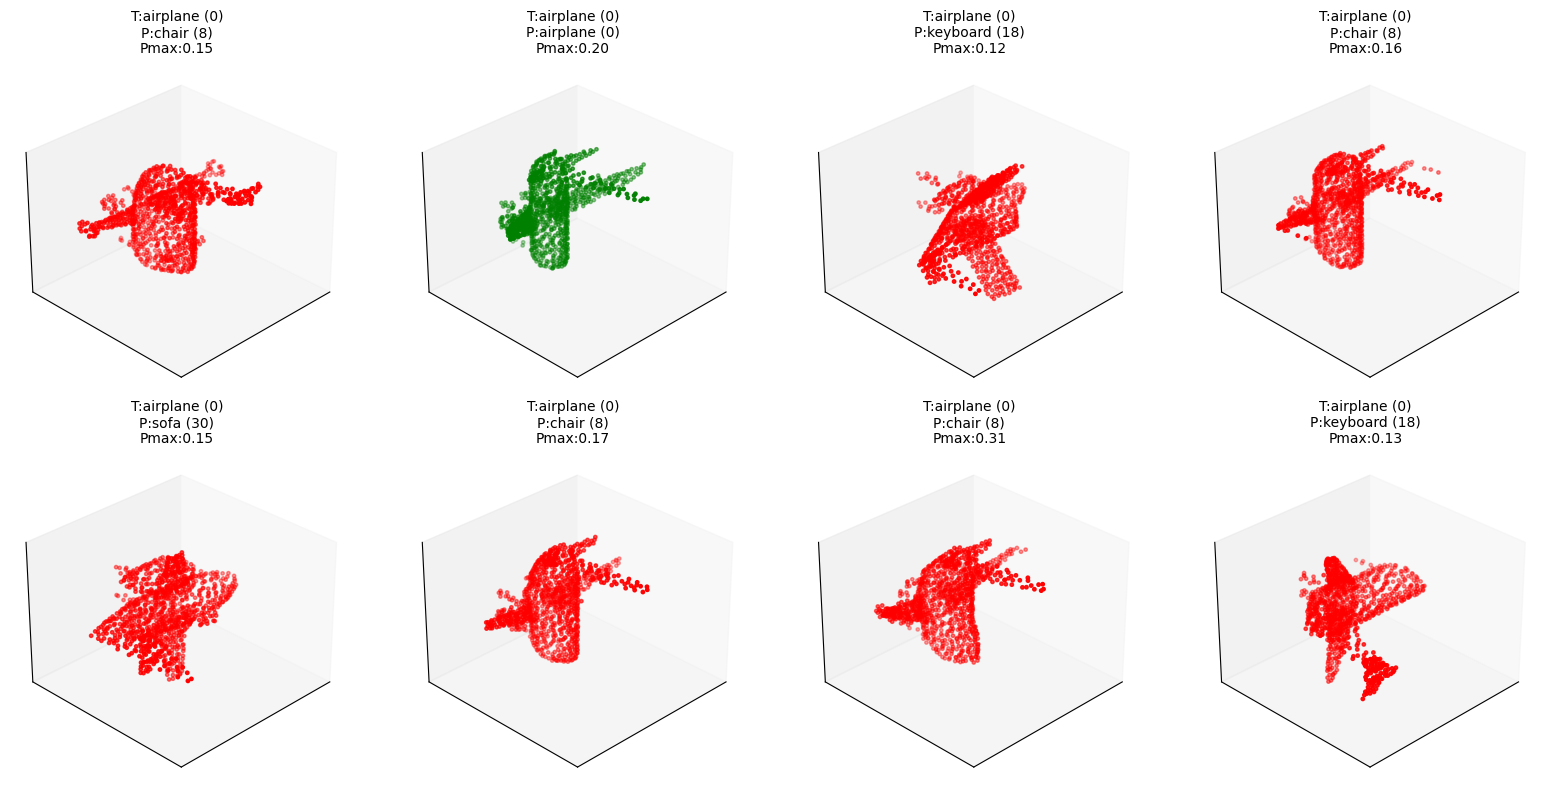

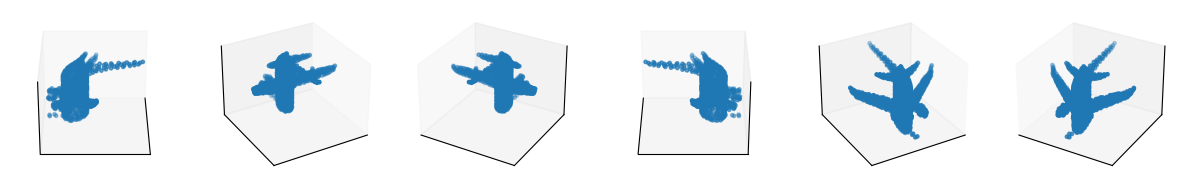

In [ ]:
# Visualisation des prédictions — coller dans Colab
import os
import math
import torch
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401

# --- Configuration utilisateur ---
LOG_DIR = "/content/drive/MyDrive/vnn_logs/dgcnn_aligned"  # chemin où se trouve checkpoints/best_model.pth
N_EXAMPLES = 8       # nombre d'exemples à afficher
COLS = 4             # colonnes de la grille d'affichage
POINT_SIZE = 6       # taille des points dans le scatter
SAVE_DIR = "/content/drive/MyDrive/vnn_visualizations"  # où sauvegarder les images
os.makedirs(SAVE_DIR, exist_ok=True)
# -----------------------------------

# --- helper : charger noms de classes ModelNet40 (si présent) ---
def load_label_names():
    candidates = [
        "/content/vnn/data/modelnet40_normal_resampled/modelnet40_shape_names.txt",
        "/content/vnn/data/modelnet40_normal_resampled/modelnet40_shape_names.txt".replace("vnn/data","data"),
        "/content/drive/MyDrive/vnn_logs/modelnet40_shape_names.txt",
        "/content/vnn/data/modelnet40_shape_names.txt",
    ]
    for p in candidates:
        if os.path.exists(p):
            with open(p, "r") as f:
                names = [l.strip() for l in f.readlines() if l.strip()]
            print("Loaded label names from", p)
            return names
    # fallback: numeric labels
    print("Label names file not found, using numeric labels.")
    return [str(i) for i in range(40)]

label_names = load_label_names()

# --- Charger checkpoint si classifier n'existe pas ---
try:
    classifier  # si déjà défini dans l'environnement
    print("Classifier trouvé en mémoire.")
except NameError:
    # crée le modèle et le charge si nécessaire
    print("Chargement du modèle depuis checkpoint...")
    import importlib
    # tu peux adapter le module suivant si tu utilises vn_dgcnn_cls etc.
    model_name = "vn_pointnet_cls"  # adapte si nécessaire
    MODEL = importlib.import_module(model_name)
    args = type("A", (), {"gpu":"0", "normal":False})()  # objet minimal si requis par get_model
    classifier = MODEL.get_model(args, 40, normal_channel=False).cuda()
    ckpt = torch.load(os.path.join(LOG_DIR, "checkpoints", "best_model.pth"), weights_only=False)
    classifier.load_state_dict(ckpt["model_state_dict"])
    classifier.eval()
    print("Checkpoint chargé.")

# --- Vérification du testDataLoader ---
try:
    testDataLoader
except NameError:
    raise RuntimeError("Le DataLoader 'testDataLoader' n'existe pas dans la session. Charge le dataset comme dans test_cls.py avant d'exécuter ce bloc.")

# --- Collecte d'exemples et prédictions ---
examples = []
labels_true = []
labels_pred = []
probs_pred = []

it = iter(testDataLoader)
collected = 0
with torch.no_grad():
    while collected < N_EXAMPLES:
        try:
            points_batch, target_batch = next(it)
        except StopIteration:
            break
        # points_batch : (B, N, 3) ou (B, 3, N) suivant l'implémentation
        B = points_batch.shape[0]
        for i in range(B):
            if collected >= N_EXAMPLES:
                break
            pts = points_batch[i]
            # remettre en forme pour le modèle : (B, 3, N)
            if pts.ndim == 2 and pts.shape[1] == 3:
                pts_for_model = pts.transpose(0,1).unsqueeze(0)  # (1, 3, N)
            elif pts.ndim == 2 and pts.shape[0] == 3:
                pts_for_model = pts.unsqueeze(0)
            else:
                # fallback try
                pts_for_model = pts.transpose(0,1).unsqueeze(0)
            pts_cuda = pts_for_model.cuda().float()
            out, _ = classifier(pts_cuda)  # out shape (1, num_class)
            prob = torch.softmax(out, dim=1).cpu().numpy()[0]
            pred_idx = int(out.data.max(1)[1].cpu().item())
            true_idx = int(target_batch[i,0].item()) if target_batch.ndim>1 else int(target_batch[i].item())
            # points for plotting (N,3)
            if pts.ndim == 2 and pts.shape[1] == 3:
                pts_np = pts.cpu().numpy()
            else:
                pts_np = pts.transpose(0,1).cpu().numpy()
            examples.append(pts_np)
            labels_true.append(true_idx)
            labels_pred.append(pred_idx)
            probs_pred.append(prob)
            collected += 1

if len(examples) == 0:
    raise RuntimeError("Aucun exemple collecté depuis testDataLoader (vérifie batch_size et loader)")

# --- Affichage en grille (matplotlib 3D) ---
rows = math.ceil(N_EXAMPLES / COLS)
fig = plt.figure(figsize=(4*COLS, 4*rows))
for idx, pts in enumerate(examples):
    ax = fig.add_subplot(rows, COLS, idx+1, projection='3d')
    color = 'g' if labels_true[idx] == labels_pred[idx] else 'r'
    ax.scatter(pts[:,0], pts[:,1], pts[:,2], s=POINT_SIZE, c=color, depthshade=True)
    title = f"T:{label_names[labels_true[idx]]} ({labels_true[idx]})\nP:{label_names[labels_pred[idx]]} ({labels_pred[idx]})\nPmax:{probs_pred[idx].max():.2f}"
    ax.set_title(title, fontsize=10)
    ax.set_xticks([]); ax.set_yticks([]); ax.set_zticks([])
    ax.view_init(elev=30, azim=45)
plt.tight_layout()
out_path = os.path.join(SAVE_DIR, "predictions_grid.png")
plt.savefig(out_path, dpi=200)
print("Figure saved to:", out_path)
plt.show()

# --- Option : afficher un exemple en plusieurs vues (si utile pour rapport) ---
def show_multiple_views(points_np, n_views=6, size=(15,6)):
    fig = plt.figure(figsize=size)
    for i in range(n_views):
        ax = fig.add_subplot(1, n_views, i+1, projection='3d')
        ax.scatter(points_np[:,0], points_np[:,1], points_np[:,2], s=POINT_SIZE)
        ax.view_init(elev=30, azim=60*i)
        ax.set_xticks([]); ax.set_yticks([]); ax.set_zticks([])
    plt.show()

# montrer le premier exemple en plusieurs vues
show_multiple_views(examples[1], n_views=6)


Ce bloc de code sert à capturer les features intermédiaires générées par le modèle pour un nuage de points donné, en attachant un hook sur la couche conv_pos du classificateur.

Il prend un exemple du test set, effectue un forward pass, et stocke les features dans feat_orig.

Cela est utile pour analyser le comportement interne du réseau, par exemple pour tester l’invariance aux rotations et pour la suite.

In [ ]:
import torch # Ensure torch is imported

# Get one batch of points to work with for rotation invariance test
# Assuming testDataLoader is available from previous cells like nkUTqDfVgubk
points, _ = next(iter(testDataLoader))
points = points[0].unsqueeze(0).transpose(2, 1).cuda() # Take first item from batch, make (1, 3, N)
print(f"Shape of input points for original pass: {points.shape}") # Debugging

global saved # Declare saved as global to ensure persistence across cells
saved = {} # Re-initialize saved for this specific test, ensuring it's fresh

def hook_fn(module, input, output):
    saved["feat"] = output.detach()
    print(f"Shape of feature captured by hook: {output.shape}") # Debugging

handle = classifier.feat.conv_pos.register_forward_hook(hook_fn)

# Forward pass for original points
classifier(points)
global feat_orig # Declare feat_orig as global to make it accessible later
feat_orig = saved["feat"].detach() # Capture original features explicitly
print(f"Shape of feat_orig (after assignment): {feat_orig.shape}") # Debugging

handle.remove()
# `saved["feat"]` now contains the original features, which are also stored in `feat_orig`.


Shape of input points for original pass: torch.Size([1, 3, 1024])
Shape of feature captured by hook: torch.Size([1, 21, 3, 1024, 20])
Shape of feat_orig (after assignment): torch.Size([1, 21, 3, 1024, 20])


Ce bloc applique une rotation aléatoire à un nuage de points et capture les features intermédiaires du modèle (feat_rot) pour tester l’invariance aux rotations.
Ensuite, il affiche le premier exemple du dataset en 3D de manière interactive avec Plotly afin de mieux visualiser l'exemple.
En sortie, on voit également les formes des tenseurs :

points_rot : (1, 3, 1024)

feat_rot : (1, 21, 3, 1024, 20)

In [ ]:
from pytorch3d.transforms import random_rotations
import plotly.graph_objects as go

R = random_rotations(1, device='cuda')[0]

# Fix: Change points @ R.T to R @ points to correctly apply rotation
# Use the 'points' variable defined in Ogj0Ef9foLcD
points_rot = (R @ points)
print(f"Shape of rotated points: {points_rot.shape}") # Debugging

# The hook_fn is already defined (globally from Ogj0Ef9foLcD) and will update the global saved dict
handle = classifier.feat.conv_pos.register_forward_hook(hook_fn) # Re-register the hook for this pass

classifier(points_rot);

global feat_rot # Declare feat_rot as global to make it accessible later
feat_rot = saved["feat"].detach() # Capture rotated features explicitly
print(f"Shape of feat_rot (after assignment): {feat_rot.shape}") # Debugging

handle.remove()


# Get one example points_np from `examples` list for interactive plot
if 'examples' in globals() and len(examples) > 0:
    example_points_np = examples[0]

    # Create a Plotly 3D scatter plot
    fig = go.Figure(data=[go.Scatter3d(
        x=example_points_np[:, 0],
        y=example_points_np[:, 1],
        z=example_points_np[:, 2],
        mode='markers',
        marker=dict(
            size=2,
            color=example_points_np[:, 2], # Color by Z-coordinate for better visualization
            colorscale='Viridis',
            opacity=0.8
        )
    )])

    # Update layout for better interactivity
    fig.update_layout(
        title='Interactive 3D Point Cloud (First Example)',
        scene=dict(
            xaxis_title='X',
            yaxis_title='Y',
            zaxis_title='Z',
            aspectmode='data' # Keep aspect ratio fixed
        ),
        height=600,
        width=800
    )

    fig.show()
else:
    print("No examples available for interactive plotting. Please ensure the visualization cell runs first.")


Shape of rotated points: torch.Size([1, 3, 1024])
Shape of feature captured by hook: torch.Size([1, 21, 3, 1024, 20])
Shape of feat_rot (after assignment): torch.Size([1, 21, 3, 1024, 20])


Ce bloc ci-dessous vérifie que le modèle est équivariant aux rotations :

On récupère les features originales et rotées du modèle.

On applique manuellement la rotation sur les features originales pour obtenir feat_expected.

On calcule l’erreur relative entre feat_rot et feat_expected.

On visualise en 3D les vecteurs de features sur les points, avant et après rotation, pour voir comment ils tournent avec l’objet.

DEBUG: Initial feat_orig tensor shape: torch.Size([1, 21, 3, 1024, 20])
DEBUG: Initial feat_rot tensor shape: torch.Size([1, 21, 3, 1024, 20])
Shape of R_np: (3, 3)
Shape of feat_orig_np: (1, 21, 3, 1024, 20)
Shape of feat_rot_np: (1, 21, 3, 1024, 20)
Shape of feat_expected: (1, 21, 3, 1024, 20)
Relative equivariance error: 0.0032065527


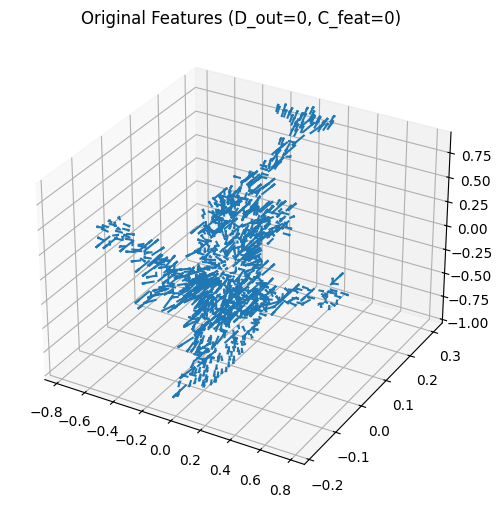

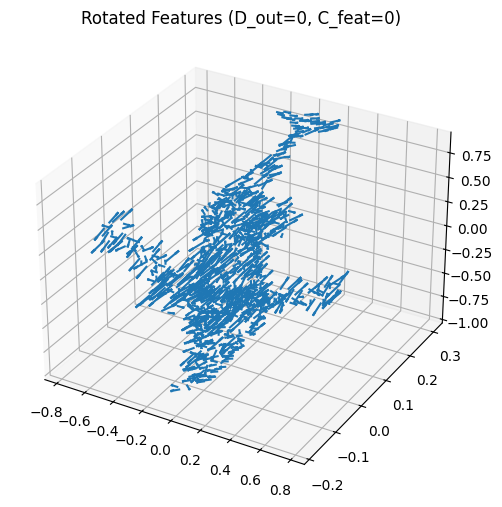

In [ ]:
import torch # Ensure torch is imported
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# global feat_orig, feat_rot, R, points (from previous cells)

print(f"DEBUG: Initial feat_orig tensor shape: {feat_orig.shape}")
print(f"DEBUG: Initial feat_rot tensor shape: {feat_rot.shape}")

# feat_orig and feat_rot are already (1, D_out, Vec_dim, N_points, C_features)

# Convert to numpy
feat_orig_np = feat_orig.cpu().numpy()
feat_rot_np = feat_rot.cpu().numpy()
R_np = R.cpu().numpy() # R is (3,3) from random_rotations

print(f"Shape of R_np: {R_np.shape}")
print(f"Shape of feat_orig_np: {feat_orig_np.shape}")
print(f"Shape of feat_rot_np: {feat_rot_np.shape}")

# Manual application of rotation
# feat_orig_np has shape (Batch, D_out, Vec_dim, N_points, C_features) -> (1, 21, 3, 1024, 20)
# R_np has shape (Vec_dim_in, Vec_dim_out) -> (3, 3)

# 1. Move the vector dimension (index 2) to the last position for batch matrix multiplication
# From (B, D_out, Vec_dim, N_points, C_features) to (B, D_out, N_points, C_features, Vec_dim)
feat_orig_permuted = np.transpose(feat_orig_np, (0, 1, 3, 4, 2))
# Shape is now (1, 21, 1024, 20, 3)

# 2. Apply the rotation matrix
# This performs (..., Vec_dim) @ (Vec_dim, Vec_dim)
feat_expected_permuted = feat_orig_permuted @ R_np.T # Note: R_np.T for right-multiplication
# Shape remains (1, 21, 1024, 20, 3)

# 3. Move the vector dimension back to its original position (index 2)
# From (B, D_out, N_points, C_features, Vec_dim) to (B, D_out, Vec_dim, N_points, C_features)
feat_expected = np.transpose(feat_expected_permuted, (0, 1, 4, 2, 3))
# Final shape is (1, 21, 3, 1024, 20)

print(f"Shape of feat_expected: {feat_expected.shape}")


# Calculate equivariance error
error = np.linalg.norm(feat_rot_np - feat_expected) / (np.linalg.norm(feat_expected) + 1e-8)
print("Relative equivariance error:", error)

# For visualization:
# P is global from Ogj0Ef9foLcD: points (tensor) was (1, 3, 1024).
P_quiver = points[0].cpu().numpy().T # (3, 1024) -> (1024, 3)

# V_quiver should be (N_points, 3)
# feat_orig_np is (Batch, D_out, Vec_dim, N_points, C_features) -> (1, 21, 3, 1024, 20)
# We need to select one Batch (b), one D_out (x) and one C_feature (c), then take the 3-vector across N_points.
# feat_orig_np[b_idx, x_idx, :, n_idx, c_idx] gives a (3,) vector
# To get (N_points, 3): feat_orig_np[b_idx, x_idx, :, :, c_feat_idx].T
b_idx = 0
d_out_idx = 0
c_feat_idx = 0
V_quiver = feat_orig_np[b_idx, d_out_idx, :, :, c_feat_idx].T # (3, 1024) -> (1024, 3)

fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111, projection='3d')
ax.quiver(
    P_quiver[:,0], P_quiver[:,1], P_quiver[:,2],
    V_quiver[:,0], V_quiver[:,1], V_quiver[:,2],
    length=0.05, normalize=True
)
plt.title(f"Original Features (D_out={d_out_idx}, C_feat={c_feat_idx})")
plt.show()

# Visualize rotated features
V_rot_quiver = feat_rot_np[b_idx, d_out_idx, :, :, c_feat_idx].T
fig_rot = plt.figure(figsize=(6,6))
ax_rot = fig_rot.add_subplot(111, projection='3d')
ax_rot.quiver(
    P_quiver[:,0], P_quiver[:,1], P_quiver[:,2],
    V_rot_quiver[:,0], V_rot_quiver[:,1], V_rot_quiver[:,2],
    length=0.05, normalize=True
)
plt.title(f"Rotated Features (D_out={d_out_idx}, C_feat={c_feat_idx})")
plt.show()
